<span style="font-size: 150%;color:white;background:#1155cc"> A task for the recruitment process

<span style="font-size: 150%;color:white;background:red">Wojciech Moszczyński



<span style="font-size: 300%;color:white;background:black">neural network   
    
    from:
https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly.


<span style="font-size: 150%;background: white;font-weight:normal;color:#1155cc"> For the first 10 products, please conduct the exploratory analysis and compute the forecast for the next 7 weeks.  

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import torch

import warnings 
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I download data - I do not need standardized sales because the primary data is enough for me.

In [2]:
cols = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", nrows=1).columns
df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv", usecols=cols[:53])
df.tail()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
806,P815,0,0,1,0,0,2,1,0,0,...,0,1,1,0,0,1,0,0,2,0
807,P816,0,1,0,0,1,2,2,6,0,...,3,3,4,2,4,5,5,5,6,5
808,P817,1,0,0,0,1,1,2,1,1,...,2,0,0,2,2,0,0,0,4,3
809,P818,0,0,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,2,0
810,P819,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I remember having to make a forecast for the first 10 products. The time series is too small to forecast. Only 52 values (52 weeks) is not a time series that allows you to build an effective forecasting model. In turn, there are as many as 811 products, which is a lot. This can be changed by entering the item index as a single independent variable.
Then we will get 811 times 52 variables = 42172 rows which gives a considerable number to do a forecasting model. Rule of thumb - even though I only have to forecast for the first 10 items - I am making a model for all 811 items.

In [3]:
df.shape

(811, 53)

In [4]:
df2 = df.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
df2

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">The data is complete

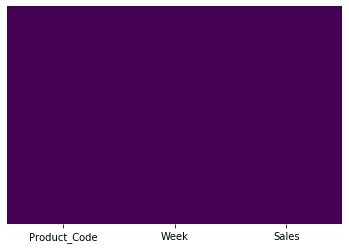

In [5]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> Removal of the letters W and P
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I want to have everything in numeric format for text-based databases because I'm going to be using the data to build forecasting models.

In [6]:
df2.Product_Code = df2.Product_Code.str.replace('P', '').astype(int)
df2.Week = df2.Week.str.replace('W', '').astype(int)
df2

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [7]:
df2.dtypes

Product_Code    int64
Week            int64
Sales           int64
dtype: object

max: 73
min: 0


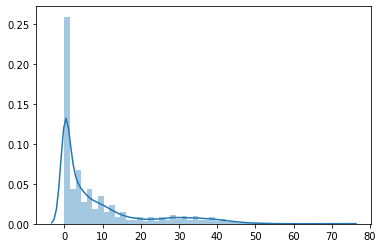

In [8]:
print('max:',df2['Sales'].max())
print('min:',df2['Sales'].min())

sns.distplot(np.array(df2['Sales']))

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">The population is not normally distributed, but I don't need to have the resultant populations in the normal distribution. It is recommended but not required. Therefore, I am not going to standardize the result variables.

In [9]:
df2.shape

(42172, 3)

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">Then we will get 811 times 52 variables = 42172 rows which gives a considerable number to do a forecasting model.

<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> We create additional synthetic variables
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">Now I create synthetic variables, i.e. independent variables that do not exist but are made of existing independent variables. Since we have practically no variable except the week number and the commodity index, we create synthetic variables from the result variable. These variables are a shift of the price one or several weeks back and the difference between the previous and the current price.

In [10]:
df2['Sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales'].shift()
df2['Sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales'].shift(2)
df2['Sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales'].shift(3)
df2['Sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales'].shift(4)
df2['Sales_last_5_week'] = df2.groupby(['Product_Code'])['Sales'].shift(5)
df2['Sales_last_6_week'] = df2.groupby(['Product_Code'])['Sales'].shift(6)
df2['Sales_last_7_week'] = df2.groupby(['Product_Code'])['Sales'].shift(7)
df2

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week
0,1,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
42167,815,51,0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
42168,816,51,5,6.0,5.0,5.0,5.0,4.0,2.0,4.0
42169,817,51,3,4.0,0.0,0.0,0.0,2.0,2.0,0.0
42170,818,51,0,2.0,0.0,0.0,0.0,1.0,1.0,0.0


<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We check if the synthetic variables 'shift' are correctly created

In [11]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==2)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Sales_last_2_week',
                                                                'Sales_last_3_week',
                                                                'Sales_last_4_week']] 


,Product_Code,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week
5678,2,3,6.0,1.0,7.0,2.0
6489,2,3,3.0,6.0,1.0,7.0
7300,2,3,3.0,3.0,6.0,1.0
8111,2,2,3.0,3.0,3.0,6.0
8922,2,2,2.0,3.0,3.0,3.0
9733,2,6,2.0,2.0,3.0,3.0
10544,2,2,6.0,2.0,2.0,3.0


In [12]:
df2['Diff_sales_last_1_week'] = df2.groupby(['Product_Code'])['Sales_last_1_week'].diff()
df2['Diff_sales_last_2_week'] = df2.groupby(['Product_Code'])['Sales_last_2_week'].diff()
df2['Diff_sales_last_3_week'] = df2.groupby(['Product_Code'])['Sales_last_3_week'].diff()
df2['Diff_sales_last_4_week'] = df2.groupby(['Product_Code'])['Sales_last_4_week'].diff()
df2['Diff_sales_last_5_week'] = df2.groupby(['Product_Code'])['Sales_last_5_week'].diff()
df2['Diff_sales_last_6_week'] = df2.groupby(['Product_Code'])['Sales_last_6_week'].diff()
df2['Diff_sales_last_7_week'] = df2.groupby(['Product_Code'])['Sales_last_7_week'].diff()

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We check if the synthetic variables 'diff' are correctly created

In [13]:
df2[df2.Week.isin([7,8,9,10,11,12,13])&(df2.Product_Code ==4)][['Product_Code',
                                                                'Sales',
                                                                'Sales_last_1_week',
                                                                'Diff_sales_last_1_week',
                                                                'Sales_last_4_week',
                                                                'Diff_sales_last_4_week']]  

,Product_Code,Sales,Sales_last_1_week,Diff_sales_last_1_week,Sales_last_4_week,Diff_sales_last_4_week
5680,4,13,9.0,3.0,5.0,-8.0
6491,4,13,13.0,4.0,9.0,4.0
7302,4,11,13.0,0.0,6.0,-3.0
8113,4,8,11.0,-2.0,9.0,3.0
8924,4,4,8.0,-3.0,13.0,4.0
9735,4,5,4.0,-4.0,13.0,0.0
10546,4,4,5.0,1.0,11.0,-2.0


<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc"> One method of improving the quality of the model is to create a large number of synthetic variables using loops. Synthetic variables as a combination of various means, differences, shifts and logarithms. Then such a large number of independent variables can be subjected to one of the variable elimination methods. This is how you get the best synthetic variables. Since this is a verification task, I inform you that it is possible.

<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc"> We remove the poems from NaN

In [14]:
print('Before dropna:',df2.shape)
df2 = df2.dropna(how ='any')
print('After dropna: ',df2.shape)

Before dropna: (42172, 17)
After dropna:  (35684, 17)


In [15]:
df2.head(3)

,Product_Code,Week,Sales,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
6488,1,8,6,21.0,14.0,12.0,13.0,8.0,10.0,12.0,7.0,2.0,-1.0,5.0,-2.0,-2.0,1.0
6489,2,8,3,3.0,6.0,1.0,7.0,2.0,3.0,6.0,-3.0,5.0,-6.0,5.0,-1.0,-3.0,-1.0
6490,3,8,12,13.0,7.0,8.0,10.0,9.0,8.0,11.0,6.0,-1.0,-2.0,1.0,1.0,-3.0,4.0


<span style="font-size: 140%;background: white;font-weight:normal;color:#1155cc">Dividing time series data into training and test sets.

<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc">I split the set for training data for the first 42 weeks, then I separate the 44 and 45 test data set. Finally, as instructed, I allow a period of 7 weeks to make a forecast for 10 products. This will be the week: 45, 46, 47, 48, 49, 50, 51, 52. I will use this data at the end of the task when I have my model ready.

In [16]:
for week in range(42,44):
    train = df2[df2['Week'] < week]   ## okres treningowy do 42 tygodnia
    val = df2[df2['Week'] == week]    ## okres testowy od 43 tygodnia włącznie do 45 tygodnia 
                                        ## 45-52 tydzień to okres super testowy 7 tygodni

    X_train, X_test = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    y_train, y_test = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

### I specify what is X and what is y

### <span style="color:green"> Określam co jest X a co y

<span style="font-size: 110%;background:##ffe599">Wynik (ilość rowerów wypożyczonych) przed skalowaniem</span>  

In [17]:
y_train[:5]

array([ 6,  3, 12, 13,  9])

In [18]:
y_test[:5]

array([ 7,  4, 14, 10, 11])

<span style="font-size: 110%;background:##ffe599">Zmienne opisujące przed skalowaniem

In [19]:
X_train[:5]

,Product_Code,Week,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
6488,1,8,21.0,14.0,12.0,13.0,8.0,10.0,12.0,7.0,2.0,-1.0,5.0,-2.0,-2.0,1.0
6489,2,8,3.0,6.0,1.0,7.0,2.0,3.0,6.0,-3.0,5.0,-6.0,5.0,-1.0,-3.0,-1.0
6490,3,8,13.0,7.0,8.0,10.0,9.0,8.0,11.0,6.0,-1.0,-2.0,1.0,1.0,-3.0,4.0
6491,4,8,13.0,9.0,6.0,9.0,5.0,13.0,8.0,4.0,3.0,-3.0,4.0,-8.0,5.0,-4.0
6492,5,8,14.0,9.0,7.0,6.0,11.0,13.0,5.0,5.0,2.0,1.0,-5.0,-2.0,8.0,-3.0


In [20]:
X_test[:5]

,Product_Code,Week,Sales_last_1_week,Sales_last_2_week,Sales_last_3_week,Sales_last_4_week,Sales_last_5_week,Sales_last_6_week,Sales_last_7_week,Diff_sales_last_1_week,Diff_sales_last_2_week,Diff_sales_last_3_week,Diff_sales_last_4_week,Diff_sales_last_5_week,Diff_sales_last_6_week,Diff_sales_last_7_week
34873,1,43,4.0,11.0,7.0,17.0,12.0,9.0,10.0,-7.0,4.0,-10.0,5.0,3.0,-1.0,-4.0
34874,2,43,2.0,5.0,2.0,3.0,7.0,2.0,5.0,-3.0,3.0,-1.0,-4.0,5.0,-3.0,-5.0
34875,3,43,6.0,5.0,3.0,9.0,12.0,12.0,6.0,1.0,2.0,-6.0,-3.0,0.0,6.0,-3.0
34876,4,43,9.0,6.0,12.0,8.0,8.0,6.0,8.0,3.0,-6.0,4.0,0.0,2.0,-2.0,-11.0
34877,5,43,7.0,8.0,5.0,5.0,8.0,8.0,4.0,-1.0,3.0,0.0,-3.0,0.0,4.0,-3.0


### Scaling (normalization) of the X value

X should never be too big. Ideally, it should be in the range [-1, 1]. If this is not the case, normalize the input.

### <span style="color:green"> Skalowanie (normalizacja) wartości X

<span style="color:green"> X nigdy nie powinien być zbyt duży. Idealnie powinien być w zakresie [-1, 1]. Jeśli tak nie jest, należy znormalizować dane wejściowe.

In [21]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

print(np.round(X_train.std(), decimals=4), np.round(X_train.mean(), decimals=4))

1.0 0.0


In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_test = sc.fit_transform(X_test)

print(np.round(X_test.std(), decimals=4), np.round(X_test.mean(), decimals=4))

0.9682 0.0


In [23]:
y_train = (y_train / 100)  # max test score is 100
#print(y.head(3))
print(np.round(y_train.std(), decimals=4), np.round(y_train.mean(), decimals=4))

0.1201 0.0884


In [24]:
y_test = (y_test / 100)  # max test score is 100
#print(y.head(3))
print(np.round(y_test.std(), decimals=4), np.round(y_test.mean(), decimals=4))

0.1124 0.0832


### Creates random input and output

### <span style="color:green"> Tworzy losowe dane wejściowe i wyjściowe 

In [25]:
import torch
import numpy as np

#X = X.values       #- jak była normalizacja to to nie działa
X_train = torch.tensor(X_train)
print(X_train[:3])

tensor([[-1.7224, -1.6833,  1.0057,  0.4196,  0.2507,  0.3273, -0.0842,  0.0749,
          0.2333,  1.5197,  0.4382, -0.2045,  1.0763, -0.4174, -0.4184,  0.2175],
        [-1.7182, -1.6833, -0.4866, -0.2401, -0.6529, -0.1630, -0.5718, -0.4913,
         -0.2503, -0.6383,  1.0836, -1.2766,  1.0763, -0.2047, -0.6310, -0.2065],
        [-1.7140, -1.6833,  0.3424, -0.1577, -0.0779,  0.0822, -0.0029, -0.0869,
          0.1527,  1.3039, -0.2073, -0.4189,  0.2224,  0.2207, -0.6310,  0.8535]],
       dtype=torch.float64)


In [26]:
X_train = X_train.type(torch.FloatTensor)
print(X_train[:3])

tensor([[-1.7224, -1.6833,  1.0057,  0.4196,  0.2507,  0.3273, -0.0842,  0.0749,
          0.2333,  1.5197,  0.4382, -0.2045,  1.0763, -0.4174, -0.4184,  0.2175],
        [-1.7182, -1.6833, -0.4866, -0.2401, -0.6529, -0.1630, -0.5718, -0.4913,
         -0.2503, -0.6383,  1.0836, -1.2766,  1.0763, -0.2047, -0.6310, -0.2065],
        [-1.7140, -1.6833,  0.3424, -0.1577, -0.0779,  0.0822, -0.0029, -0.0869,
          0.1527,  1.3039, -0.2073, -0.4189,  0.2224,  0.2207, -0.6310,  0.8535]])


In [27]:
#X = X.values       #- jak była normalizacja to to nie działa
X_test = torch.tensor(X_test)
print(X_test[:3])

tensor([[-1.7224,  0.0000, -0.3875,  0.2478, -0.1068,  0.8403,  0.3327,  0.0854,
          0.1814, -1.6591,  0.9297, -2.4464,  1.2700,  0.6765, -0.2349, -0.9518],
        [-1.7182,  0.0000, -0.5638, -0.2910, -0.5584, -0.4618, -0.1111, -0.5599,
         -0.2755, -0.7315,  0.6939, -0.2914, -0.8923,  1.1559, -0.6784, -1.1887],
        [-1.7140,  0.0000, -0.2111, -0.2910, -0.4681,  0.0962,  0.3327,  0.3619,
         -0.1841,  0.1962,  0.4580, -1.4886, -0.6520, -0.0426,  1.3175, -0.7149]],
       dtype=torch.float64)


In [28]:
X_test = X_test.type(torch.FloatTensor)
print(X_test[:3])

tensor([[-1.7224,  0.0000, -0.3875,  0.2478, -0.1068,  0.8403,  0.3327,  0.0854,
          0.1814, -1.6591,  0.9297, -2.4464,  1.2700,  0.6765, -0.2349, -0.9518],
        [-1.7182,  0.0000, -0.5638, -0.2910, -0.5584, -0.4618, -0.1111, -0.5599,
         -0.2755, -0.7315,  0.6939, -0.2914, -0.8923,  1.1559, -0.6784, -1.1887],
        [-1.7140,  0.0000, -0.2111, -0.2910, -0.4681,  0.0962,  0.3327,  0.3619,
         -0.1841,  0.1962,  0.4580, -1.4886, -0.6520, -0.0426,  1.3175, -0.7149]])


In [29]:
y_train = torch.tensor(y_train)
print(y_train[:3])

tensor([0.0600, 0.0300, 0.1200], dtype=torch.float64)


In [30]:
y_test = torch.tensor(y_test)
print(y_test[:3])

tensor([0.0700, 0.0400, 0.1400], dtype=torch.float64)


### TRanspends the resulting vector to become a column
### <span style="color:green"> TRansponuje wektor wynikowy aby stał się kolumną</span>
# ZMIENNE TRENINGOWE

In [31]:
y_train = y_train.type(torch.FloatTensor)

In [32]:
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)

X_train: torch.Size([28385, 16])
y_train: torch.Size([28385])


Dodanie jednego wymiaru do wektora wynikowego

In [33]:
y_train = y_train.view(y_train.shape[0],1)
y_train.shape

torch.Size([28385, 1])

In [34]:
X_train

tensor([[-1.7224, -1.6833,  1.0057,  ..., -0.4174, -0.4184,  0.2175],
        [-1.7182, -1.6833, -0.4866,  ..., -0.2047, -0.6310, -0.2065],
        [-1.7140, -1.6833,  0.3424,  ...,  0.2207, -0.6310,  0.8535],
        ...,
        [ 1.7308,  1.6833, -0.6524,  ...,  0.0080,  0.0068,  0.0055],
        [ 1.7351,  1.6833, -0.7353,  ...,  0.0080,  0.0068,  0.0055],
        [ 1.7393,  1.6833, -0.7353,  ...,  0.0080, -0.4184,  0.6415]])

# ZMIENNE TESTOWE

In [35]:
y_test = y_test.type(torch.FloatTensor)

In [36]:
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X_test: torch.Size([811, 16])
y_test: torch.Size([811])


Dodanie jednego wymiaru do wektora wynikowego

In [37]:
y_test = y_test.view(y_test.shape[0],1)
y_test.shape

torch.Size([811, 1])

In [38]:
X_test

tensor([[-1.7224,  0.0000, -0.3875,  ...,  0.6765, -0.2349, -0.9518],
        [-1.7182,  0.0000, -0.5638,  ...,  1.1559, -0.6784, -1.1887],
        [-1.7140,  0.0000, -0.2111,  ..., -0.0426,  1.3175, -0.7149],
        ...,
        [ 1.7308,  0.0000, -0.5638,  ..., -0.0426, -0.0131, -0.0041],
        [ 1.7351,  0.0000, -0.7401,  ..., -0.0426, -0.0131, -0.0041],
        [ 1.7393,  0.0000, -0.7401,  ..., -0.0426, -0.0131, -0.4779]])

### I specify what is X and what is y

### <span style="color:green"> Określam co jest X a co y

<span style="font-size: 110%;background:##ffe599">Wynik (ilość rowerów wypożyczonych) przed skalowaniem</span>  

In [39]:
y_train[:5]

tensor([[0.0600],
        [0.0300],
        [0.1200],
        [0.1300],
        [0.0900]])

In [40]:
y_test[:5]

tensor([[0.0700],
        [0.0400],
        [0.1400],
        [0.1000],
        [0.1100]])

<span style="font-size: 110%;background:##ffe599">Zmienne opisujące przed skalowaniem

In [41]:
X_train[:5]

tensor([[-1.7224e+00, -1.6833e+00,  1.0057e+00,  4.1962e-01,  2.5066e-01,
          3.2729e-01, -8.4220e-02,  7.4904e-02,  2.3329e-01,  1.5197e+00,
          4.3819e-01, -2.0455e-01,  1.0763e+00, -4.1744e-01, -4.1840e-01,
          2.1749e-01],
        [-1.7182e+00, -1.6833e+00, -4.8662e-01, -2.4013e-01, -6.5288e-01,
         -1.6296e-01, -5.7184e-01, -4.9125e-01, -2.5033e-01, -6.3827e-01,
          1.0836e+00, -1.2766e+00,  1.0763e+00, -2.0472e-01, -6.3099e-01,
         -2.0652e-01],
        [-1.7140e+00, -1.6833e+00,  3.4245e-01, -1.5766e-01, -7.7903e-02,
          8.2165e-02, -2.9491e-03, -8.6854e-02,  1.5268e-01,  1.3039e+00,
         -2.0726e-01, -4.1895e-01,  2.2242e-01,  2.2071e-01, -6.3099e-01,
          8.5351e-01],
        [-1.7097e+00, -1.6833e+00,  3.4245e-01,  7.2780e-03, -2.4218e-01,
          4.5769e-04, -3.2803e-01,  3.1754e-01, -8.9125e-02,  8.7231e-01,
          6.5334e-01, -6.3335e-01,  8.6284e-01, -1.6937e+00,  1.0697e+00,
         -8.4255e-01],
        [-1.7055e+00

In [42]:
X_test[:5]

tensor([[-1.7224e+00,  0.0000e+00, -3.8747e-01,  2.4784e-01, -1.0680e-01,
          8.4026e-01,  3.3275e-01,  8.5363e-02,  1.8139e-01, -1.6591e+00,
          9.2971e-01, -2.4464e+00,  1.2700e+00,  6.7651e-01, -2.3490e-01,
         -9.5179e-01],
        [-1.7182e+00,  0.0000e+00, -5.6381e-01, -2.9103e-01, -5.5840e-01,
         -4.6182e-01, -1.1110e-01, -5.5992e-01, -2.7547e-01, -7.3146e-01,
          6.9387e-01, -2.9140e-01, -8.9230e-01,  1.1559e+00, -6.7845e-01,
         -1.1887e+00],
        [-1.7140e+00,  0.0000e+00, -2.1113e-01, -2.9103e-01, -4.6808e-01,
          9.6217e-02,  3.3275e-01,  3.6191e-01, -1.8410e-01,  1.9616e-01,
          4.5802e-01, -1.4886e+00, -6.5204e-01, -4.2559e-02,  1.3175e+00,
         -7.1486e-01],
        [-1.7097e+00,  0.0000e+00,  5.3380e-02, -2.0122e-01,  3.4479e-01,
          3.2110e-03, -2.2329e-02, -1.9119e-01, -1.3520e-03,  6.5998e-01,
         -1.4287e+00,  9.0580e-01,  6.8730e-02,  4.3682e-01, -4.5667e-01,
         -2.6103e+00],
        [-1.7055e+00

In [43]:
print('X_train: ',X_train.shape)
print('X_test:  ',X_test.shape)
print('----------------------------------------------------')
print('y_train: ',y_train.shape)
print('y_test:  ',y_test.shape)

X_train:  torch.Size([28385, 16])
X_test:   torch.Size([811, 16])
----------------------------------------------------
y_train:  torch.Size([28385, 1])
y_test:   torch.Size([811, 1])


## Defining the neural network
##### Programowanie torch.nn.Module

In [44]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

##### Definicja krztałtu sieci

In [45]:
N, D_in = X_train.shape
N, D_out = y_train.shape

H = 100                            ## liczba wymiarów warstwy wewnętrznej 
device = torch.device('cpu')

In [46]:
net = torch.nn.Sequential(
        torch.nn.Linear(D_in,  H),   # Warstwa WEJŚCIOA
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, H),        # warstwa wewnętrzna
        torch.nn.LeakyReLU(),
        torch.nn.Linear(H, D_out),    # warstwa wyjściowa
    ).to(device)  

In [47]:
net(X_train)

tensor([[0.2672],
        [0.1937],
        [0.2822],
        ...,
        [0.0872],
        [0.0886],
        [0.0996]], grad_fn=<AddmmBackward>)

## Алгоритм оптимизации:

##### Optymalizator 
lr: Speed of learning -> The speed at which our model updates the weights in the cells each time backward propagation is carried out

lr: Szybkość uczenia się -> Szybkość, z jaką nasz model aktualizuje wagi w komórkach za każdym razem, gdy przeprowadzana jest wsteczna propagacja

In [48]:
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False) #-2.401
#optimizer = torch.optim.SGD(net.parameters(), lr=0.1) #-4.086
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) #-5.298
#optimizer = torch.optim.Adamax(net.parameters(), lr=0.01) #-6.610
#optimizer = torch.optim.ASGD(net.parameters(), lr=0.01, lambd=0.0001, alpha=0.15, t0=000000.0) #-2.315
#optimizer = torch.optim.LBFGS(net.parameters(), lr=0.01, max_iter=20, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
#optimizer = torch.optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08) #-5.152
#optimizer = torch.optim.Rprop(net.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))  #R2:-7.388

## Определение функции потерь
to jest R2 dla regresji

In [49]:
loss_func = torch.nn.MSELoss()

### Definiowanie procesu nauki i nauka

In [50]:
inputs = X_train                          #1. deklarujemy x i y do nauki
outputs = y_train
for i in range(1000):                          #2. pętla 1050 powtórzeń (epok)
   prediction = net(inputs)
   loss = loss_func(prediction, outputs) 
   optimizer.zero_grad()
   loss.backward()        
   optimizer.step()       

   if i % 200 == 0:  
      print(i, loss.item())     # <=# wartości y, a funkcja straty zwraca Tensor zawierający stratę.



0 0.017548827454447746
200 0.0013017962919548154
400 0.0012092810356989503
600 0.0011572629446163774
800 0.0011332607828080654


### There are many potential reasons. Most likely exploding gradients. The two things to try first:

- Normalize the inputs
- Lower the learning rate




### <span style="color:green">Istnieje wiele potencjalnych przyczyn. Najprawdopodobniej wybuchające gradienty. Dwie rzeczy do wypróbowania w pierwszej kolejności:

 - <span style="color:green">- Normalizuj wejścia
 - <span style="color:green">- Obniż tempo uczenia się

###  Forecast based on the model
-  substitute the same equations that were in the model
-  The following loss result shows the last model sequence
-  Loss shows how much the model is wrong (loss = sum of error squares) after the last learning sequence

### <span style="color:green"> Prognoza na podstawie modelu
- <span style="color:green"> podstawiamy te same równania, które były w modelu 
- <span style="color:green"> Poniższy wynik loss pokazuje ostatnią sekwencje modelu
- <span style="color:green"> Loss pokazuje ile myli się model (loss = suma kwadratu błedów) po ostatniej sekwencji uczenia się 

<span style="font-size: 180%;background:##ffe599"> Podtsawiam pod model

In [51]:
with torch.no_grad():
    y_pred = net(X_test)  
    loss = (y_pred - y_test).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 1.01408410


<span style="color:green">Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierać 1 neuron, każda prognoza będzie zawierać 1 wartości. Przykładowo pierwsze 5 przewidywanych wartości wygląda następująco:

### We save the whole model

### <span style="color:green"> Zapisujemy cały model

In [52]:
torch.save(net,'/home/wojciech/Pulpit/7/byk25.pb')

### We play the whole model
### <span style="color:green"> Odtwarzamy cały model
    
    Model teraz nie nazywa się 'net' tylo 'KOT'

In [53]:
KOT = torch.load('/home/wojciech/Pulpit/7/byk25.pb')
KOT

Sequential(
  (0): Linear(in_features=16, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [54]:
with torch.no_grad():
    y_interp = KOT(X_test)  
    loss = (y_interp - y_test).pow(2).mean()

    print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.00125041


In [55]:
y_interp

tensor([[ 8.3352e-02],
        [ 4.1011e-02],
        [ 6.3378e-02],
        [ 8.7185e-02],
        [ 6.1095e-02],
        [ 3.7329e-02],
        [ 5.9086e-02],
        [ 1.1818e-01],
        [ 7.9140e-02],
        [ 1.7528e-01],
        [ 1.1832e-01],
        [ 5.7329e-02],
        [ 5.9013e-02],
        [ 1.1187e-01],
        [ 3.1934e-01],
        [ 3.0115e-01],
        [ 3.2690e-01],
        [ 2.9763e-01],
        [ 3.4528e-01],
        [ 8.5366e-02],
        [ 8.2620e-02],
        [ 7.8711e-02],
        [ 4.9169e-02],
        [ 3.4595e-01],
        [ 3.0672e-01],
        [ 8.1900e-02],
        [ 3.4304e-01],
        [ 3.2254e-01],
        [ 9.5410e-02],
        [ 2.6190e-01],
        [ 1.0234e-01],
        [ 6.8375e-02],
        [ 8.2666e-02],
        [ 3.3044e-01],
        [ 3.5949e-01],
        [ 3.1115e-01],
        [ 3.4242e-01],
        [ 3.1513e-01],
        [ 3.1359e-01],
        [ 3.0651e-01],
        [ 3.1243e-01],
        [ 3.0601e-01],
        [ 3.3077e-01],
        [ 3

### By substituting other independent variables, you can get a vector of output variables
We choose a random record from the tensor

### <span style="color:green">Podstawiając inne zmienne niezależne można uzyskać wektor zmiennych wyjściowych
<span style="color:green"> Wybieramy sobie jakąś losowy rekord z tensora

In [56]:
y_interp = y_interp*10
foka = y_interp.cpu().detach().numpy()
df11 = pd.DataFrame(foka)
df11.columns = ['y_interp']
#df11=np.round(df11.y_interp)
df11.head(3)

,y_interp
0,0.833517
1,0.410106
2,0.633778


In [57]:
y_test = y_test*10
foka = y_test.cpu().detach().numpy()
df_t = pd.DataFrame(foka)
df_t.columns = ['y']
df_t.head(3)

,y
0,0.7
1,0.4
2,1.4


In [58]:
NOWA = pd.merge(df_t,df11, how='inner', left_index=True, right_index=True)
NOWA.head(3)

,y,y_interp
0,0.7,0.833517
1,0.4,0.410106
2,1.4,0.633778


In [59]:
NOWA.to_csv('/home/wojciech/Pulpit/7/NOWA.csv')

Text(0.5, 1.0, 'COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

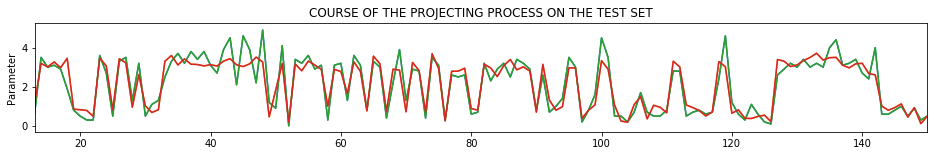

In [60]:
fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['y', 'y_interp']:
    ax.plot(NOWA, label=ewa)
    
ax.set_xlim(13, 150)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

<Figure size 432x288 with 0 Axes>

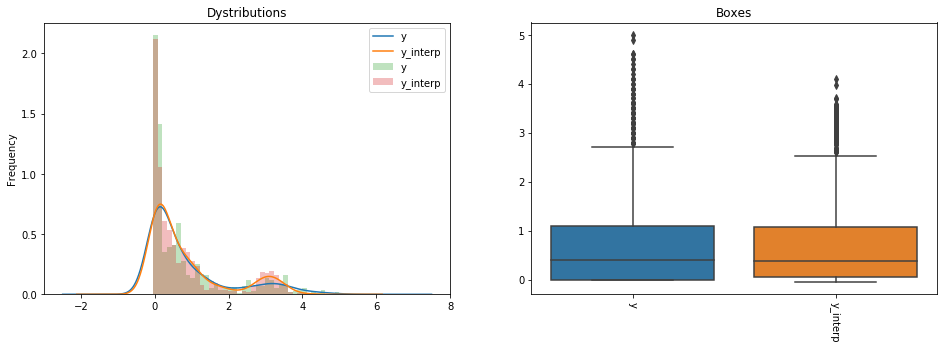

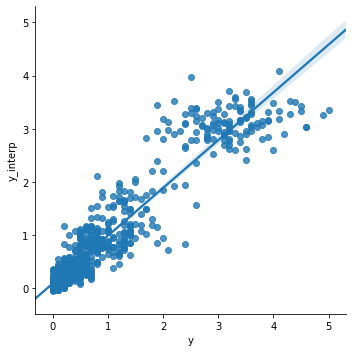

In [61]:
## marginesy
plt.subplots_adjust( left = None , bottom = None , right = None , top = None , wspace = None , hspace = None )
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
NOWA.plot.kde(ax=ax, legend=True, title='Histogram: y vs. y_interp')
NOWA.plot.hist(density=True,bins=40, ax=ax, alpha=0.3)
ax.set_title("Dystributions")

ax = plt.subplot(1, 2, 2)
sns.boxplot(data = NOWA)
plt.xticks(rotation=-90)
ax.set_title("Boxes")


sns.lmplot(data=NOWA, x='y', y='y_interp')

# Regression_Assessment

In [62]:
## Robi ocenę tylko dla jednej zmiennej

def Regression_Assessment(y, y_pred):
    
    from sklearn.metrics import r2_score 
    import scipy.stats as stats
    from statsmodels.graphics.gofplots import qqplot
    from matplotlib import pyplot
       
    print('-----two methods--------------')
    SS_Residual = sum((y-y_pred)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print('r2_score:           %0.3f' % r_squared)
    #print('adjusted_r_squared: %0.3f' % adjusted_r_squared)
    #print('----r2_score------secound-method--------')  
    print('r2_score:           %0.3f' % r2_score(y, y_pred))  
    print()
    print('-------------------------------')
    MAE = (abs(y-y_pred)).mean()
    print('Mean absolute error     MAE:  %0.2f ' %  MAE)
    RMSE = np.sqrt(((y-y_pred)**2).mean())
    print('Root mean squared error RMSE: %0.2f ' %  RMSE)
    pt = (100*(y-y_pred))/y
    MAPE = (abs(pt)).mean()
    print('Mean absolute error     MAPE: %0.2f ' %  MAPE)
    print('-------------------------------')
    
    stat,pvalue0 = stats.ttest_1samp(a=(y-y_pred),popmean=0.0)

    if pvalue0 > 0.01:
        print('t-test H0: the sum of the model residuals is zero')
        print('OKAY! Model remains do not differ from zero - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue0) 
    else:     
        print('Bad - Model remains DIFFERENT FROM ZERO - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue0)  
    print('--------------------------------------------------------------------------------------------') 
  
       
    stat,pvalue2_1 = stats.shapiro(y)
    stat,pvalue2_2 = stats.shapiro(y_pred)

    if pvalue2_1 > 0.01:
        #print('Shapiro-Wilk H0: y have normal distribution?--------------------------------')
        print('OK Shapiro-Wolf! y have normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue2_1) 
    else:     
        print('Bad Shapiro-Wilk - y NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_1)  
        print('--------------------------------------------------------------------------------------------')
    if pvalue2_2 > 0.01:
        #print('Shapiro-Wilk: y_pred have a normal distribution?--')
        print('OK Shapiro-Wolf! y_pred has a normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject h0)'% pvalue2_2) 
    else:     
        print('Bad Shapiro-Wilk y_pred NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_2)  
    
    qqplot(y, line='s')
    pyplot.show()

    qqplot(y_pred, line='s')
    pyplot.show()
       
    print('--------------------------------------------------------------------------------------------')
        
    stat,pvalue3 = stats.kruskal(y_pred,y)
    stat,pvalue4 = stats.f_oneway(y_pred,y)

    if pvalue2_1 < 0.01 or pvalue2_2 < 0.01:
        print('Шапиро-Вилк: Переменные не имеют нормального распределения! Не могу сделать анализ ANOV')
     
        if pvalue3 > 0.01:
            print('Kruskal-Wallis NON-PARAMETRIC TEST: whether empirical forecast and observations. have equal means?')
            print('OKAY! Kruskal-Wallis H0: forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue3) 
        else:     
            print('Bad - Kruskal-Wallis: forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue3)  
    
    else:

        if pvalue4 > 0.01:
            print('F-test (ANOVA): whether empirical forecast and observations. have equal means?--------------------------------')
            print('OKAY! forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue4) 
        else:     
            print('Bad - forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue4)  
    print('--------------------------------------------------------------------------------------------')

In [63]:
y = NOWA['y']
y_interp = NOWA['y_interp']

Regression_Assessment(y, y_interp)

-----two methods--------------


NameError: name 'X' is not defined

# Sprawdzenie na odłożonym miesiącu 12 miesiąc


In [ ]:
gf = df[df['mnth']==12]
print(gf.shape)
gf.head(4)

In [ ]:
X12 = gf.drop(['cnt','registered','casual'],1)
y12 = gf['cnt']

Normalizacja 12- tego miesiąca

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X12 = sc.fit_transform(X12)

print(np.round(X12.std(), decimals=2), np.round(X12.mean(), decimals=2))

In [ ]:
X12 = torch.tensor(X12)
X12 = X12.type(torch.FloatTensor)
print(X12[:3])

In [ ]:
y12 = (y12/ 100)  # max test score is 100
print(y.head(3))
print('---------------------')
print(np.round(y12.std(), decimals=2), np.round(y12.mean(), decimals=2))

In [ ]:
y12.shape

In [ ]:
y12 = y12.values

In [ ]:
y12 = torch.tensor(y12)
print(y12[:3])

In [ ]:
y12 = y12.type(torch.FloatTensor)

In [ ]:
print('X12:',X12.shape)
print('y12:',y12.shape)

bez sensu

In [ ]:
with torch.no_grad():
    y_model = KOT(X12)  
    loss = (y_model - y12).pow(2).sum()

    print(f'Loss train_set: {loss:.8f}')

In [ ]:
y_model = y_model*100
foka = y_model.cpu().detach().numpy()
df11 = pd.DataFrame(foka)
df11.columns = ['y_model']
df11=np.round(df11.y_model)
df11.head(3)

In [ ]:
df11 = pd.DataFrame(df11)
df11.head(5)

In [ ]:
y12 = y12*100
y12 = np.round(y12)
foka = y12.cpu().detach().numpy()
df_t = pd.DataFrame(foka)
df_t.columns = ['y12']
df_t.head(5)

In [ ]:
Super_NOWA = pd.merge(df_t,df11, how='inner', left_index=True, right_index=True)
Super_NOWA.head(3)

In [ ]:
fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['y12', 'y_model']:
    ax.plot(Super_NOWA, label=ewa)
    
ax.set_xlim(1000, 1300)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

In [ ]:
## marginesy
plt.subplots_adjust( left = None , bottom = None , right = None , top = None , wspace = None , hspace = None )
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
Super_NOWA.plot.kde(ax=ax, legend=True, title='Histogram: y12 vs. y_model')
Super_NOWA.plot.hist(density=True,bins=40, ax=ax, alpha=0.3)
ax.set_title("Dystributions")

ax = plt.subplot(1, 2, 2)
sns.boxplot(data = Super_NOWA)
plt.xticks(rotation=-90)
ax.set_title("Boxes")


sns.lmplot(data=Super_NOWA, x='y12', y='y_model')

In [ ]:
y = Super_NOWA['y12']
y_pred = Super_NOWA['y_model']

Regression_Assessment(y, y_pred)